# Redes neuronales convolucionales para la reconstrucción de la vorticidad probadas con observaciones aéreas
## Pérez-Corona, Y., Torres, H.

### Ejemplo base
En este código obtenemos la vorticidad de datos del DopplerScatt a partir de los modelos de Xiao et al. (2023),  son Redes Neuronales Convolucionales tipo Unet. Cada modelo está organizado como se muestra en la Figura 1.

![Unet](unet.jpeg)

La Unet consta de dos partes para superar la pérdida de información: el codificador, que condensa la resolución variable y amplia el número de mapas características para extraer información e la entrada, mientras que el descodificador hace lo contrario, utiliza la información extraida para construir la salida. Cada capa tiene dos conjuntos de filtros de convolución de dimensión 3x3, así como normalizacón por lotes y unidades lineales exponenciales escaladas como funciones de activación.

Xiao et al. (2023) entrenaron a la Unet con datos simulados de anomalía de la altura dinámica (Sea Surface Height, SSH) y probaron su habilidad para reconstruir la vorticidad superficial. Tomaron muestreos de 64 X 64 para que fueran capaces de captar la submesoescala y la mesoescala. Para la prueba cortaron a la variable objetivo en regiones de 64 X 64 presentadas aleatoriamente pero superponiéndolas en un intervalo de 5 para que los datos del límite tuvieran suficiente infomación. Utilizaron el optimizador Adam con una tasa de aprendizaje de  0,0001, tamaño de lote 32 y 100 épocas. 

#### Uso del Nootebook
Para utilizar este Notebook es necesario tener calculadas previamente las variables SSH y vorticidad de los datos DopplerScatt.

#### Importar librerías

In [1]:
from torch import nn
import torch
import torch.optim as optim
from torch.utils.data import Dataset
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import xarray as xr
import time
from scipy.stats import pearsonr  
import seaborn as sns

### Datos

#### Cargar los datos
Variable de prueba para el modelo de las observaciones aéreas. 

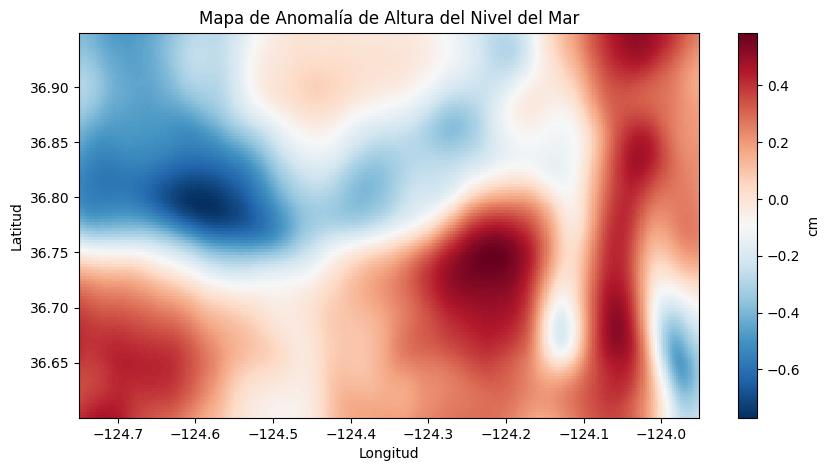

In [2]:
# Cargar el archivo .npz
archivo_npz = np.load('SSH_anomaly_from_DScatt_October_26_afternoon.npz')

# Acceder a los datos almacenados en el archivo
SSHanom = archivo_npz['SSHanom']
lat=archivo_npz['lat']
lon=archivo_npz['lon']

# Crear la visualización utilizando pcolormesh
plt.figure(figsize=(10, 5))
plt.pcolormesh(lon, lat, SSHanom, cmap='RdBu_r')
plt.colorbar(label='cm')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.title('Mapa de Anomalía de Altura del Nivel del Mar')
plt.savefig("SSH.pdf", bbox_inches = "tight")

Constantes a considerar

Aceleración de Coriolis a latitud 40°

In [3]:
f =  0.83e-4

*Nota*: Si se quiere probar con datos satelitates se deben cargar con xarray debido a que son datos NetCDF. La línea de código quedaría de la siguiente manera: 

In [4]:
# data=xr.open_dataset('dt_global_allsat_phy_l4_19970215_20210726.nc')
# data

Para estos datos utilizamos la  topografía dinámica absoluta es la altura de la superficie del mar sobre el geoide; la adt se obtiene del siguiente modo: adt=sla+mdt donde mdt es la topografía dinámica media.

In [5]:
# SSHanom = data['adt']
# SSHanom.shape

Para obtener la vorticidad de estos datos utilizamos la ecuación de vorticidad.

In [6]:
# Calcular las derivadas utilizando xarray
#du_dx = xr.apply_ufunc(np.gradient, data['ugos'], input_core_dims=[['longitude']], output_core_dims=[['longitude']],
#                       vectorize=True, dask='parallelized')
#dv_dy = xr.apply_ufunc(np.gradient, data['vgos'], input_core_dims=[['latitude']], output_core_dims=[['latitude']],
#                       vectorize=True, dask='parallelized')

# Calcular la vorticidad relativa
#vorticidad = du_dx - dv_dy

El resto del código se puede utilizar exactamente igual. Solamente es necesario tomar en cuenta las dimensiones, los datos satelitales tienen una dimensión más.

In [7]:
SSHanom.shape

(130, 297)

### Modelo
#### Definimos la Red Neuronal Convolucional (Unet) ya preentrenada de Xiao et al. (2023)

In [8]:
class UNet(nn.Module):
    def contracting_block(self, in_channels, out_channels, kernel_size=3):
        block = torch.nn.Sequential(
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=in_channels, out_channels=out_channels, padding = 1),
                    torch.nn.SELU(),
                    torch.nn.BatchNorm2d(out_channels),
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=out_channels, out_channels=out_channels, padding = 1),
                    torch.nn.SELU(),
                    torch.nn.BatchNorm2d(out_channels),
                )
        return block
        
    def expansive_block(self, in_channels, mid_channel, out_channels, kernel_size=3):
            block = torch.nn.Sequential(
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=in_channels, out_channels=mid_channel, padding = 1),
                    torch.nn.SELU(),
                    torch.nn.BatchNorm2d(mid_channel),
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=mid_channel, out_channels=out_channels, padding = 1),
                    torch.nn.SELU(),
                    torch.nn.BatchNorm2d(out_channels),
                    torch.nn.Upsample(scale_factor=2, mode='nearest'),
                    torch.nn.Conv2d(kernel_size=3, in_channels=out_channels, out_channels=out_channels, padding = 1),
                    torch.nn.SELU(),
                    torch.nn.BatchNorm2d(out_channels),
#                     torch.nn.ConvTranspose2d(in_channels=mid_channel, out_channels=out_channels, kernel_size=3, stride=2, padding=1, output_padding=1) ## padding?
                    )
            return  block

    def final_block(self, in_channels, mid_channel, out_channels, kernel_size=3):
            block = torch.nn.Sequential(
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=in_channels, out_channels=mid_channel, padding = 1),
                    torch.nn.SELU(),
                    torch.nn.BatchNorm2d(mid_channel),
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=mid_channel, out_channels=mid_channel, padding = 1),
                    torch.nn.SELU(),
                    torch.nn.BatchNorm2d(mid_channel),
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=mid_channel, out_channels=out_channels, padding=1),
                    torch.nn.SELU(),
                    torch.nn.BatchNorm2d(out_channels),
                    )
            return  block
    
    def __init__(self, in_channel, out_channel):
        super(UNet, self).__init__()
        #Encode
        self.conv_encode1 = self.contracting_block(in_channels=in_channel, out_channels=32)
        self.conv_maxpool1 = torch.nn.MaxPool2d(kernel_size=2)
        self.conv_encode2 = self.contracting_block(32, 64)
        self.conv_maxpool2 = torch.nn.MaxPool2d(kernel_size=2)
        self.conv_encode3 = self.contracting_block(64, 128)
        self.conv_maxpool3 = torch.nn.MaxPool2d(kernel_size=2)
        # Bottleneck
        self.bottleneck = torch.nn.Sequential(
                            torch.nn.Conv2d(kernel_size=3, in_channels=128, out_channels=128, padding = 1),
                            torch.nn.SELU(),
                            torch.nn.BatchNorm2d(128),
                            torch.nn.Conv2d(kernel_size=3, in_channels=128, out_channels=128, padding = 1),
                            torch.nn.SELU(),
                            torch.nn.BatchNorm2d(128),
                            torch.nn.Upsample(scale_factor=2, mode='nearest'),
                            torch.nn.Conv2d(kernel_size=3, in_channels=128, out_channels=128, padding = 1),
                            torch.nn.SELU(),
                            torch.nn.BatchNorm2d(128),
                            )
        # Decode
        self.conv_decode3 = self.expansive_block(256, 128, 64)
        self.conv_decode2 = self.expansive_block(128, 64, 32)
        self.final_layer = self.final_block(64, 32, out_channel)
        
    def crop_and_concat(self, upsampled, bypass, crop=False):
        if crop:
            c = (bypass.size()[2] - upsampled.size()[2]) // 2
            bypass = F.pad(bypass, (-c, -c, -c, -c))
        return torch.cat((upsampled, bypass), 1)

    def forward(self, x):
        # Encode
        encode_block1 = self.conv_encode1(x)
        encode_pool1 = self.conv_maxpool1(encode_block1)
        encode_block2 = self.conv_encode2(encode_pool1)
        encode_pool2 = self.conv_maxpool2(encode_block2)
        encode_block3 = self.conv_encode3(encode_pool2)
        encode_pool3 = self.conv_maxpool3(encode_block3)
        # Bottleneck
        bottleneck1 = self.bottleneck(encode_pool3)
        # Decode
        decode_block3 = self.crop_and_concat(bottleneck1, encode_block3, crop=True) ### false should work?
        cat_layer2 = self.conv_decode3(decode_block3)
        decode_block2 = self.crop_and_concat(cat_layer2, encode_block2, crop=True)
        cat_layer1 = self.conv_decode2(decode_block2)
        decode_block1 = self.crop_and_concat(cat_layer1, encode_block1, crop=True)
        final_layer = self.final_layer(decode_block1)
        return  final_layer

#### Cargamos los parámetros preentrenados con datos de simulación
EL entrenamiento y las pruebas se realizaron en regiones de la simulación de 1km; temporalmente se utilizaron 80 días de datos instantaneos de 6 horas para el entrenamiento y 10 días siguientes para la prueba (Xiao et al., 2023).
Los pesos que se tienen en este trabajo son los siguientes: el primero de ellos es el "vort_cs" entrenado con salidas de la simulación channel; el segundo "vort_summer", entrenado con salidas de la simulación LLC4320 para el verano; y el tercero "vort_winter", entrenado con salidas de la simulación LLC4320 para el invierno. Mayores detalles pueden ser consultados directamente en su artículo *Reconstruction of surface kinematics from sea surface height using neural networks*, la Unet en sus resultados capturó con éxito la mayoría de las características tanto a gran escala como a pequeña escala.

In [9]:
model = UNet(in_channel = 1, out_channel = 1)

# Sustituir en esta línea vort_cs, vort_summer o vort_winter según las necesidades.
model.load_state_dict(torch.load('vort_cs')) 

<All keys matched successfully>

#### Usamos el modelo para calcular la vorticidad en las observaciones aéreas

In [10]:
# Creamos una matriz de ceros con las dimensiones apropiadas de nuestros datos, esta es para la normalización de las predicciones
SPredNorm = np.zeros((1, 130, 297)) # Cuanto tenemos más días el 1, se sustituye por el número de días, en este caso solo hay un día.

depth = -0

# Le agregamos una dimensión a nuestros datos
xData = np.expand_dims(SSHanom, axis=0) # Cuando tenemos datos satelitales expandimos en axis=1
xData = xData.astype(np.float32)  # Convierte la entrada a tipo float32

# Creamos otra matriz para guardar las prediciones del tamaño de nuestros datos
SPred = np.zeros((1,130,297))
mask = np.zeros((130,297))

# Definimos el salto y el tamaño de la región
stride = 5
region_size = 64
t0 = time.time()

# Evaluamos al modelo por regiones de 64 X 64 que se van cortando durante el ciclo y guardamos la predicción en SPredNorm
for i in range(0, 297-region_size+1, stride):
        
    for j in range(0, 130-region_size+1, stride):
        model.eval()
        SPred[0, j:j+region_size, i:i+region_size] += np.squeeze(model( torch.tensor(np.reshape(xData[:, j:j+region_size, i:i+region_size], (1, 1, region_size, region_size))) ).detach().numpy())
        # En los datos satelitales consideramos xData[0, 0, j:j+region_size, i:i+region_size]
        mask[j:j+region_size,i:i+region_size] += 1

    SPredNorm[0,:,:] = np.divide( SPred, mask )
    
    # Visualizamos el tiempo que tarda en correr la prueba del modelo
    t1 = time.time()
    print(0, t1-t0)

C:\Users\lic.-Ing.Yuri\AppData\Local\Temp\ipykernel_6148\1585611057.py:27: RuntimeWarning: invalid value encountered in divide
  SPredNorm[0,:,:] = np.divide( SPred, mask )


0 0.4304654598236084
0 0.9610707759857178
0 1.391953468322754
0 1.80348539352417
0 2.369157075881958
0 2.7700860500335693
0 3.2583353519439697
0 4.0198588371276855
0 5.7109575271606445
0 7.061294317245483
0 7.625795364379883
0 8.082164287567139
0 8.59730076789856
0 9.027044534683228
0 9.452481031417847
0 9.88831377029419
0 10.306705713272095
0 10.731066226959229
0 11.153961181640625
0 11.581818342208862
0 12.010027170181274
0 12.447527408599854
0 12.882281303405762
0 13.322128295898438
0 13.748986959457397
0 14.172843217849731
0 14.585806369781494
0 15.031147718429565
0 15.468123435974121
0 15.961834192276001
0 16.578047275543213
0 17.13139796257019
0 17.593183279037476
0 18.01106572151184
0 18.510729551315308
0 19.028368711471558
0 19.502387285232544
0 19.97114324569702
0 20.51824188232422
0 20.98806095123291
0 21.574037075042725
0 22.57391357421875
0 23.191243410110474
0 23.792267560958862
0 24.389671087265015
0 24.91533899307251
0 25.47883367538452


#### Visualización de la salida del modelo

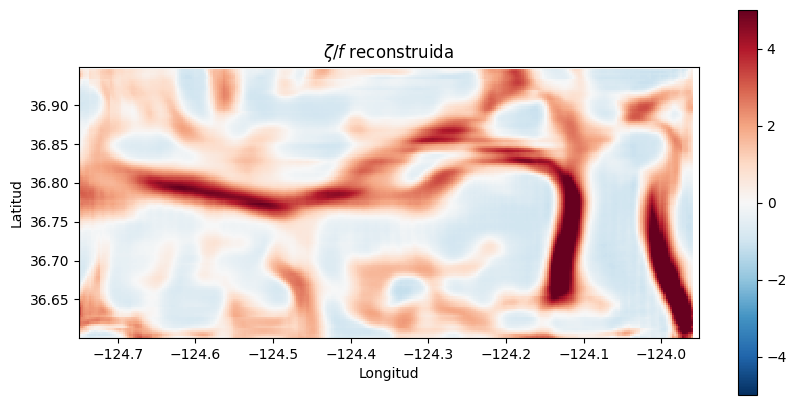

In [11]:
fig, ax = plt.subplots(figsize=(10,5))
im = ax.pcolormesh(lon, lat, SPredNorm[0,:,:], vmax=5,vmin=-5,cmap ='RdBu_r', rasterized=True)
ax.set_xlabel("Longitud")
ax.set_ylabel("Latitud")
ax.set_aspect('equal')
ax.set_title('$\zeta/f$ reconstruida')
fig.colorbar(im)
plt.savefig("RV_rec.pdf", bbox_inches = "tight")

### Comparación con los datos reales

#### Cargamos datos reales

In [12]:
data = xr.open_dataset('DScatt_IOP1_FirstProc_20221026_144400_ver_L2E_Smoothing_2000.0v3.nc').squeeze() #Carga el archivo para usar como data frame
data

<xarray.Dataset>
Dimensions:          (lats: 130, lons: 297)
Coordinates:
    lon              (lats, lons) float64 ...
    lat              (lats, lons) float64 ...
Dimensions without coordinates: lats, lons
Data variables: (12/18)
    U_detrended      (lats, lons) float64 ...
    V_detrended      (lats, lons) float64 ...
    U_std_detrended  (lats, lons) float64 ...
    V_std_detrended  (lats, lons) float64 ...
    U                (lats, lons) float64 ...
    V                (lats, lons) float64 ...
    ...               ...
    RV_hp            (lats, lons) float64 ...
    DV_hp            (lats, lons) float64 ...
    S_hp             (lats, lons) float64 ...
    RV_lp            (lats, lons) float64 ...
    DV_lp            (lats, lons) float64 ...
    S_lp             (lats, lons) float64 ...

#### Visualización de los datos reales

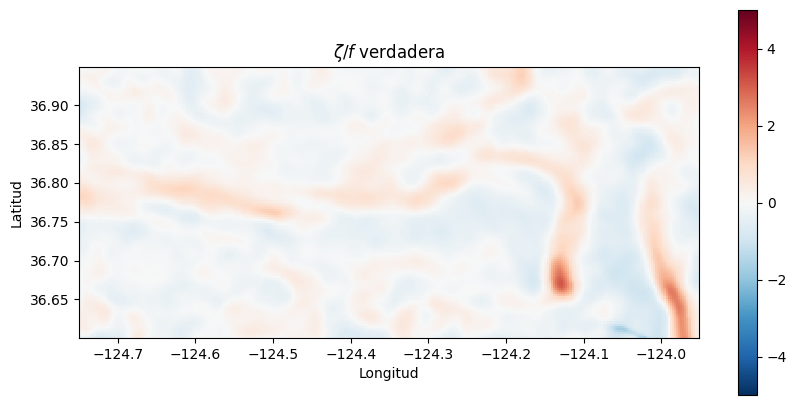

In [13]:
fig, ax = plt.subplots(figsize=(10,5))
im = ax.pcolormesh(lon, lat, data.RV_hp/f, vmax=5,vmin=-5, cmap ='RdBu_r', rasterized=True)
ax.set_xlabel("Longitud")
ax.set_ylabel("Latitud")
ax.set_aspect('equal')
ax.set_title('$\zeta/f$ verdadera')
fig.colorbar(im)
plt.savefig("RV_ver.pdf", bbox_inches = "tight")

#### Razón de Vorticidad

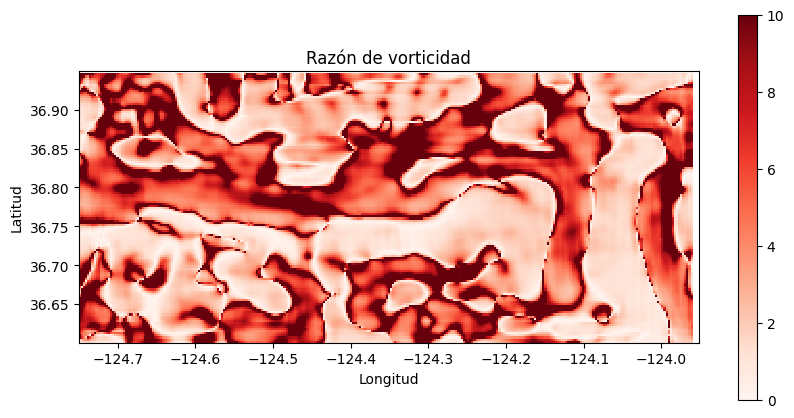

In [14]:
# Calculamos la razón
razon_vorticidad=abs(SPredNorm[0,:,:]/(data.RV_hp/f))

# Graficamos
fig, ax = plt.subplots(figsize=(10,5))
im = ax.pcolormesh(lon, lat, razon_vorticidad, vmax=10, vmin=0, cmap ='Reds', rasterized=True)
ax.set_xlabel("Longitud")
ax.set_ylabel("Latitud")
ax.set_aspect('equal')
ax.set_title('Razón de vorticidad')
fig.colorbar(im)
plt.savefig("razon.pdf", bbox_inches = "tight")

#### Calcularmos la correlación y la capacidad de predicción con respecto la vorticidad real

In [15]:
truth = (data.RV_hp.values.flatten())/f
pred =  SPredNorm[0,:,:].flatten()
truth = truth[np.isfinite(pred)]
pred = pred[np.isfinite(pred)]
print("Correlación :", pearsonr(truth, pred)[0])
skill = 1 - (((truth - pred)**2).mean()/(truth**2).mean())**(0.5)
print("Capacidad de predición:", skill)

Correlación : 0.8893080783367525
Capacidad de predición: -2.352581235112757


Correlación: 0.889 (fuerte relación lineal positiva).
Capacidad de predicción: -2.352 (sesgo negativo, indicando subestimación promedio).

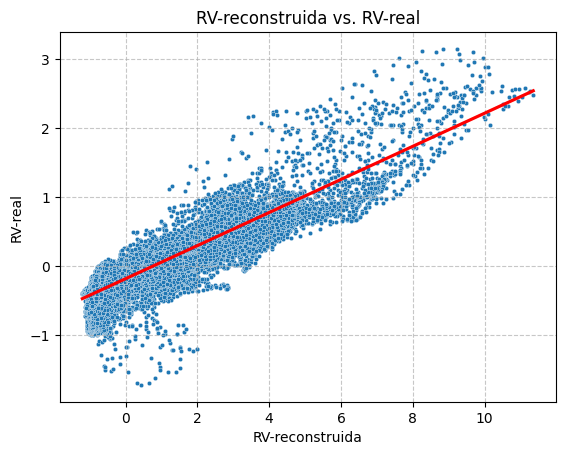

In [16]:
# Crear el scatter plot con Seaborn
sns.scatterplot(x=SPredNorm[0,:,:].flatten(), y=(data.RV_hp/f).values.flatten(), s=10)

# Añadir cuadrícula
plt.grid(True, linestyle='--', alpha=0.7)

# Añadir línea de tendencia
sns.regplot(x=SPredNorm[0,:,:].flatten(), y=(data.RV_hp/f).values.flatten(), scatter=False, color='red')

# Etiquetas y título del gráfico
plt.xlabel('RV-reconstruida')
plt.ylabel('RV-real')
plt.title('RV-reconstruida vs. RV-real')

plt.savefig("tendencia.pdf", bbox_inches = "tight")

### Referencias
Xiao, Q., Balwada, D., Jones, C. S., Herrero-González, M., Smith, K. S., & Abernathey, R. (2023). Reconstruction of surface kinematics from sea surface height using neural networks. Journal of Advances in Modeling Earth Systems, 15, doi/10.1029/2023MS003709.